```
ME72: Maestría en Métodos Cuantitativos para la Gestión y Análisis de Datos
M72109: Analisis de datos no estructurados
Universidad de Buenos Aires - Facultad de Ciencias Economicas (UBA-FCE)
Año: 2020
Profesor: Facundo Santiago
```

# Clasificación de audio utilizando embeddings

En este notebook revisaremos una de las tantas técnicas para el procesamiento de audio: embeddings

## Preparacion del ambiente

Instalamos las librerias necesarias

In [ ]:
!pip install librosa
!pip install moviepy

Descargamos el modelo preentrenado para el set de datos YouTube-100M

In [2]:
!wget -N https://storage.googleapis.com/audioset/yamnet.h5 --directory-prefix ./Models/yamnet/

--2020-09-23 20:51:44--  https://storage.googleapis.com/audioset/yamnet.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.7.208, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15296092 (15M) [application/octet-stream]
Saving to: ‘Models/yamnet.h5’

yamnet.h5           100%[===================>]  14.59M  --.-KB/s    in 0.06s   

2020-09-23 20:51:45 (237 MB/s) - ‘Models/yamnet.h5’ saved [15296092/15296092]



Descargamos algunas utilidades y librerias que nos serán de utilidad

In [ ]:
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/Models/yamnet/yamnet_class_map.csv --directory-prefix ./Models/yamnet/
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/Utils/audio_plotter.py --directory-prefix ./Utils/

Descargamos el codigo del modelo. <br />
Creditos: arXiv:1609.09430 [cs.SD][https://arxiv.org/abs/1609.09430v2]

In [ ]:
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/yamnet/yamnet.py --directory-prefix ./yamnet/
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/yamnet/params.py --directory-prefix ./yamnet/
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/yamnet/features_lib.py --directory-prefix ./yamnet/

Descargamos algunos archivos de audio de ejemplo

In [ ]:
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/Samples/127_hours_285_295_2.wav --directory-prefix ./Samples/
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Audio/Samples/Back_To_The_Future_3648_3658_6.wav --directory-prefix ./Samples/

## Classificación de audio utilizando CNNs

La performance de los modelos de clasificación de imágenes ha mejorado enormemente con la utilización de grandes conjuntos de datos como ImageNet, lo que permite utilizar grandes arquitecturas de redes neuronales basadas en convoluciones (CNN) como AlexNet, VGG, Inception y ResNet. Justamente de este último tipo hemos visto un ejemplo de como utilizar un modelo preentrenado en ImageNet para transferir los conceptos aprendidos a otro dominio. Seria posible entonces pensar que la misma ténica podría funcionar para la clasificación de audio.

### AudioSet-YouTube corpus

Equivalente a ImageNet, existe un dataset de un gran tamano sobre el cual entrenar estos grandes modelos, especificamente tratandose de audio. Este conjunto de datos, AudioSet-YouTube corpus consta de una colección de 2,084,320 clips de sonido de 10 segundos con etiquetas humanas extraídos de videos de YouTube. Estas anotaciones corresponden a 632 diferentes clases que se especifican como un gráfico jerárquico de categorías de eventos, que cubre una amplia gama de sonidos humanos y animales, instrumentos musicales y géneros, y sonidos ambientales cotidianos comunes.

Referencia: https://research.google.com/audioset/

### YAMNet 

El tamaño de este conjunto de datos nos permite examinar redes con modelos de gran capacidad, aprovechando al máximo las ideas de Computer Vision. YAMNet es un modelo que explota esta caracteristica al construir imagenes a partir de auido (llamados parches o patchs). Cada uno de estos patchs es el resultado de calcular espectrogramas log-mel, creando asi parches de imágenes 2D para utilizar en nuestro modelo. 

<img src='https://www.researchgate.net/profile/Phillip_Lobel/publication/267827408/figure/fig2/AS:295457826852866@1447454043380/Spectrograms-and-Oscillograms-This-is-an-oscillogram-and-spectrogram-of-the-boatwhistle.png' width=500 />

Estas representaciones 2D tienen dimensiones repreentando el tiempo y la frecuencia del sonido con lo cual el significado es bien distinto y por lo tanto pensar que no sería una buena opción. Sin embargo, YAMNet logra performance muy interesante que logra predecir 521 clases de eventos de audio empleando la arquitectura de convolución de Mobilenet.

El repositorio puede encontrase en: https://github.com/tensorflow/models/tree/master/research/audioset/yamnet

## Explorando los embeddings generados por YAMNet

### Instanciamos el modelo

Al igual que hicimos con varios de nuestros modelos, el primer paso para trabar con este modelo es descargar los pesos de la red neuronal. Entrenar este modelo desde zero es una tarea muy demandante de hardware teniendo en cuenta el dataset con el que estamos trabajando. Estos pesos ya fueron descargados en durante la fase de preparación del ambiente.

In [1]:
import numpy as np
import librosa

from yamnet.yamnet import yamnet_frames_model
import yamnet.yamnet as yamnet_model
from yamnet.params import Params

In [2]:
yamnet_params = Params()
class_names = yamnet_model.class_names('Models/yamnet/yamnet_class_map.csv')
yamnet = yamnet_frames_model(yamnet_params)
yamnet.load_weights('Models/yamnet/yamnet.h5')

### Representación de un archivo de audio

Como estamos acostumbrados, los tipos de datos no estructurados ofrecen desafios para procesarlos. El audio no es una exceptción ya que en general suele estar comprimido. Codecs como MP3, que ademas de ser propietario, es un formato comprimido para reducir el espacio que ocupa. Nuestros modelos no podrán operar sobre datos comprimidos y por ende deben ser convertidos a un formato como wav. En este formato, podemos cargarlos utiliando la libreria librosa

Leemos un archivo de audio para correr el modelo

In [3]:
rootdir = './Samples'

In [4]:
wav_file_name = os.path.join(rootdir, '127_hours_285_295_2.wav')
wave = librosa.load(wav_file_name, sr=16000)[0].astype(np.float32)

¿Que dimensiones tiene wave?

### Ejecución de nuestro modelo

Corremos nuestro modelo sobre el audio que acabamos de especificar. Para hacerlo, simplemente llamamos al modelo instanciado anteriormente. Este metodo devuelve 3 valores:
 - scores: Son las probabilidades de que el audio indicado pertenezca a cada una de las 521 clases que el modelo es capaz de predecir. Noten que este modelo resuelve un problema de clasificación múltiple
 - embeddings: Son los embeddings (ante-ultima capa de la red) utilizados para predecir cada una de las clases. Estos embeddings son un vector de dimensión 1024 en YAMNet
 - spectrogram: Es el espectrograma resultante del audio indicado como entrada y que se utilizo como input para la red. Este espectrograma sería el equivalente a una imágen 2D

In [5]:
scores, embeddings, spectrogram = yamnet(wave)

¿Que dimensiones tiene scores, embeddings y spectrogram? 

Podemos revisar los resultados gráficando las predicciones

In [9]:
import soundfile as sf

wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / 32768.0 #(32 kHz)

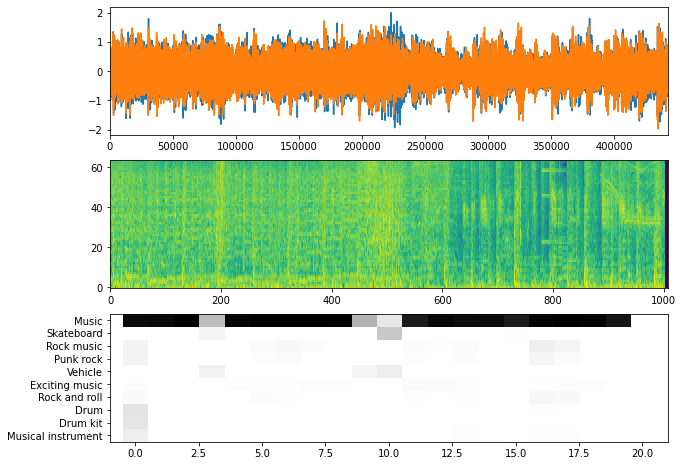

In [10]:
from Utils.audio_plotter import plot_audio_embeddings

plot_audio_embeddings(scores, embeddings, spectrogram, waveform, class_names, yamnet_params.patch_window_seconds, yamnet_params.patch_hop_seconds)